In [3]:
import numpy as np
import pandas as pd
import extinction
from astropy.io import fits
from astropy.table import Table
from helper import phys
from helper.specread import get_keck, gaplinelist
from helper.readfilter import get_UVOT_eff_wave
from helper.specread import add_telluric_circle, pblines
from helper.specread import truncate_spec, measure_flux, gaus
from helper.app2abs import add_physcol, deredden_df, app2abs_df
from allsn_info import get_at2019dge
from scipy.interpolate import splrep, splev, interp1d

import matplotlib
import matplotlib.pyplot as plt
fs= 14
matplotlib.rcParams['font.size']=fs

%matplotlib notebook

In [4]:
result = get_at2019dge()
z = result["z"]
ebv = result["ebv"]
ebv = result["ebv"]
t_max = result["t_max"]

In [5]:
from astropy.cosmology import FlatLambdaCDM
import astropy.constants as const
cosmo = FlatLambdaCDM(H0=70., Om0=0.275)
D = cosmo.luminosity_distance([0.0213])[0].value * 1e+6 # in pc

In [46]:
D / 1e+6

92.75414341506126

In [6]:
yaolist = gaplinelist(z=0)
H_list = yaolist['H_list']
FeII_list = yaolist['FeII_list']
HeI_list = yaolist['HeI_list']
HeII_list = yaolist['HeII_list']
OIII_list = yaolist['OIII_list']
OII_list = yaolist['OII_list']
OI_list = yaolist['OI_list']
SIII_list = yaolist['SIII_list']
SII_list = yaolist['SII_list']
NII_list = yaolist['NII_list']
CaII_list = yaolist['CaII_list']
NeIII_list = yaolist['NeIII_list']
ArIII_list = yaolist["ArIII_list"]
MgII_list = yaolist["MgII_list"]
CIII_list = yaolist["CIII_list"]
NIII_list = yaolist["NIII_list"]

## Host Galaxy Analysis

Updated SMA values: The actual rms in the images are 0.75 mJy for the 230 GHz image and 2.8 mJy for the 345 GHz image.

In [47]:
dt6 = get_keck(z=z, date = "20200218_Keck1_v2", vkernel = 200, t0jd = t_max, ebv = ebv)

In [8]:
# dt6["freq"] = phys.c / (dt6["wave_rest"]*1e-8)
# dt6["fnu"] = dt6["wave_rest"] * dt6['spec_obs'] / dt6["freq"]

## 1 fit the continuum, excluding major nebula lines

In [48]:
knots = np.hstack([np.linspace(3700, 4700, 6), np.linspace(5000, 9500, 3)])

Regions marked in red are removed from continuum fitting

<IPython.core.display.Javascript object>


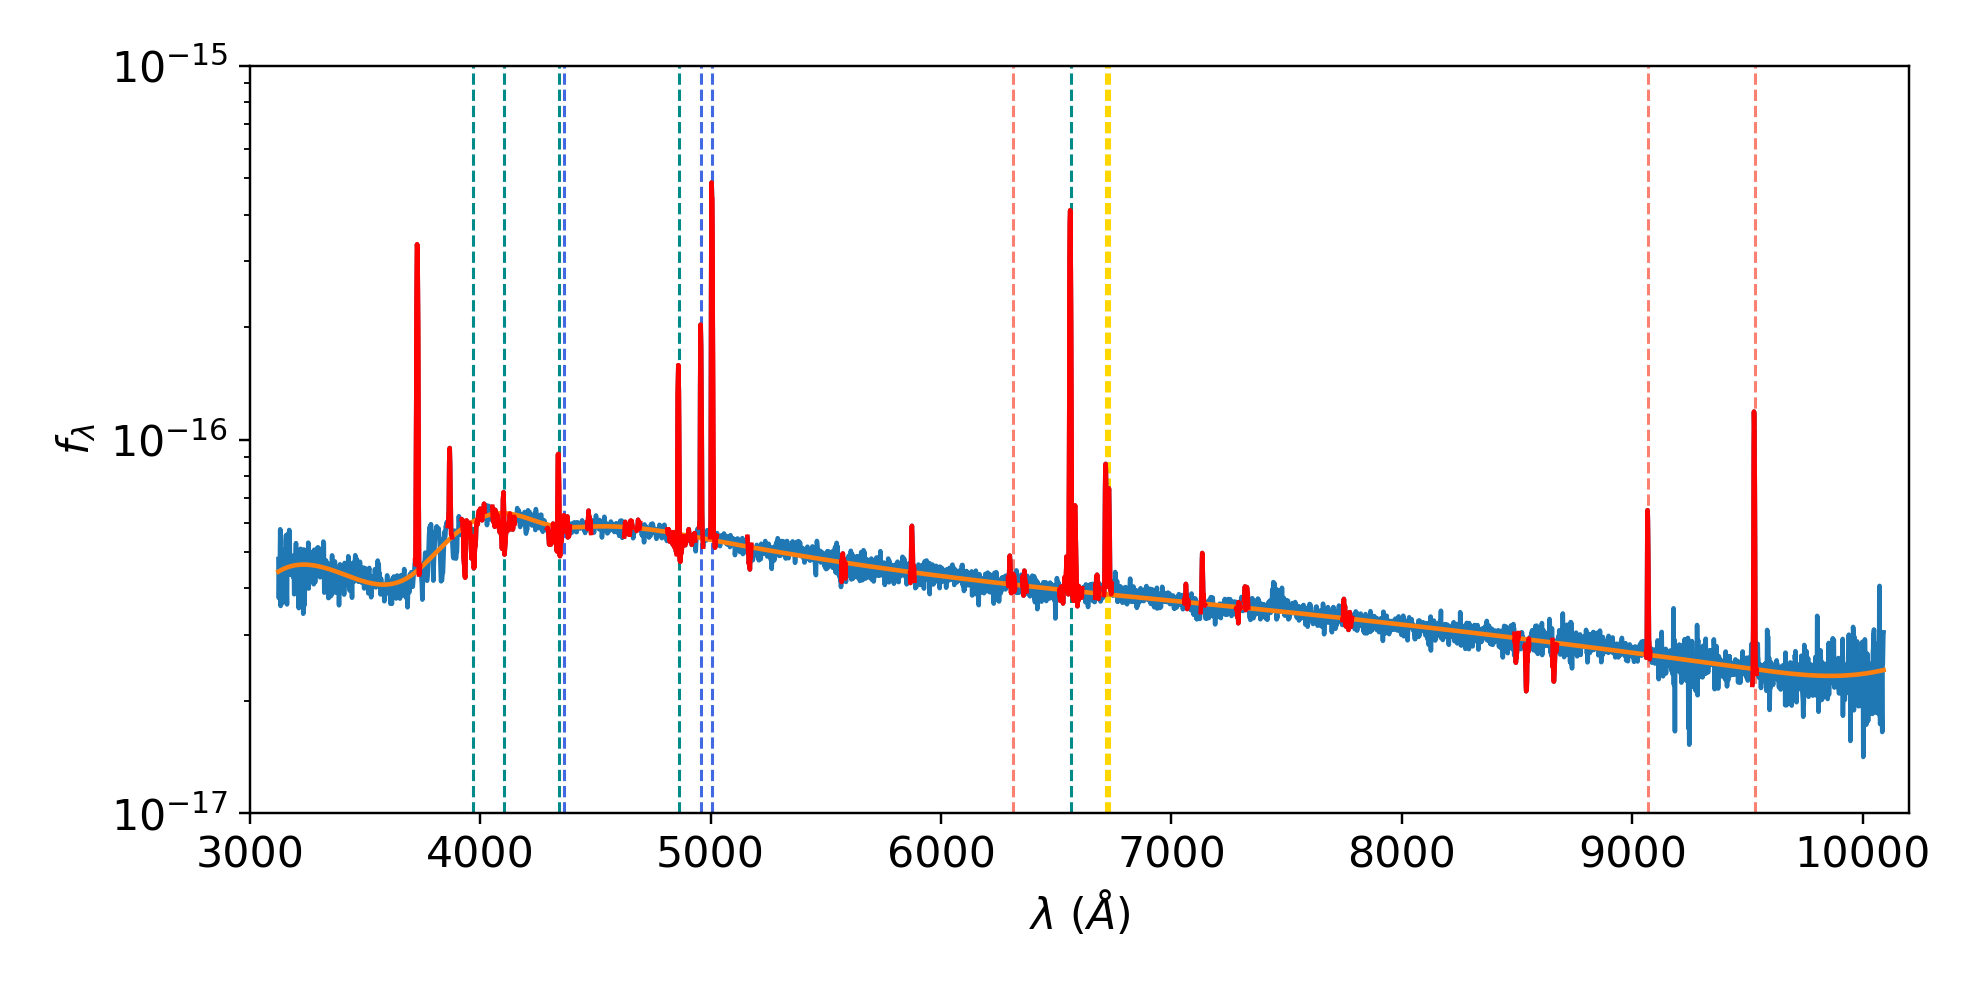

In [53]:
plt.figure(figsize=(9, 4.5))
axi = plt.subplot(111)
axi.plot(dt6["wave_rest"], dt6["spec_obs0"])
plt.semilogy()
#plt.semilogx()
axi.set_xlabel(r"$\lambda$"+" ($\AA$)")
plt.xlim(3000, 10200)
axi.set_ylabel(r"$f_\lambda$")
wv_cont_, fl_cont_ = truncate_spec(dt6["wave_rest"], dt6["spec_obs0"], axi)
t,c,k = splrep(wv_cont_, fl_cont_, k=3, task=-1, t = knots)
flux_cont = splev(dt6["wave_rest"], (t,c,k)) 

plt.plot(dt6["wave_rest"], flux_cont)

tbottom = 1e-17
tup = 1e-15
plt.ylim(tbottom, tup)
pblines(axi, H_list, color='darkcyan', tb = tbottom, tu = tup, ls = '--')
pblines(axi, OIII_list, color='royalblue', tb = tbottom, tu = tup, ls = '--')
pblines(axi, SIII_list, color='salmon', tb = tbottom, tu = tup, ls = '--')
pblines(axi, SII_list, color='gold', tb = tbottom, tu = tup, ls = '--')
plt.tight_layout()

In [54]:
flux_line = dt6["spec_obs0"] - flux_cont

H$\alpha$ is straightforward since there is no obvious absorption lines and we can simply fit a Gaussian

Line flux uncertianty are measured by generating new Gaussian parameters from the covariance matrix (Cholesky decomposition).

line width = 2.55 AA
line center is 6560.61 +- 0.05


<IPython.core.display.Javascript object>


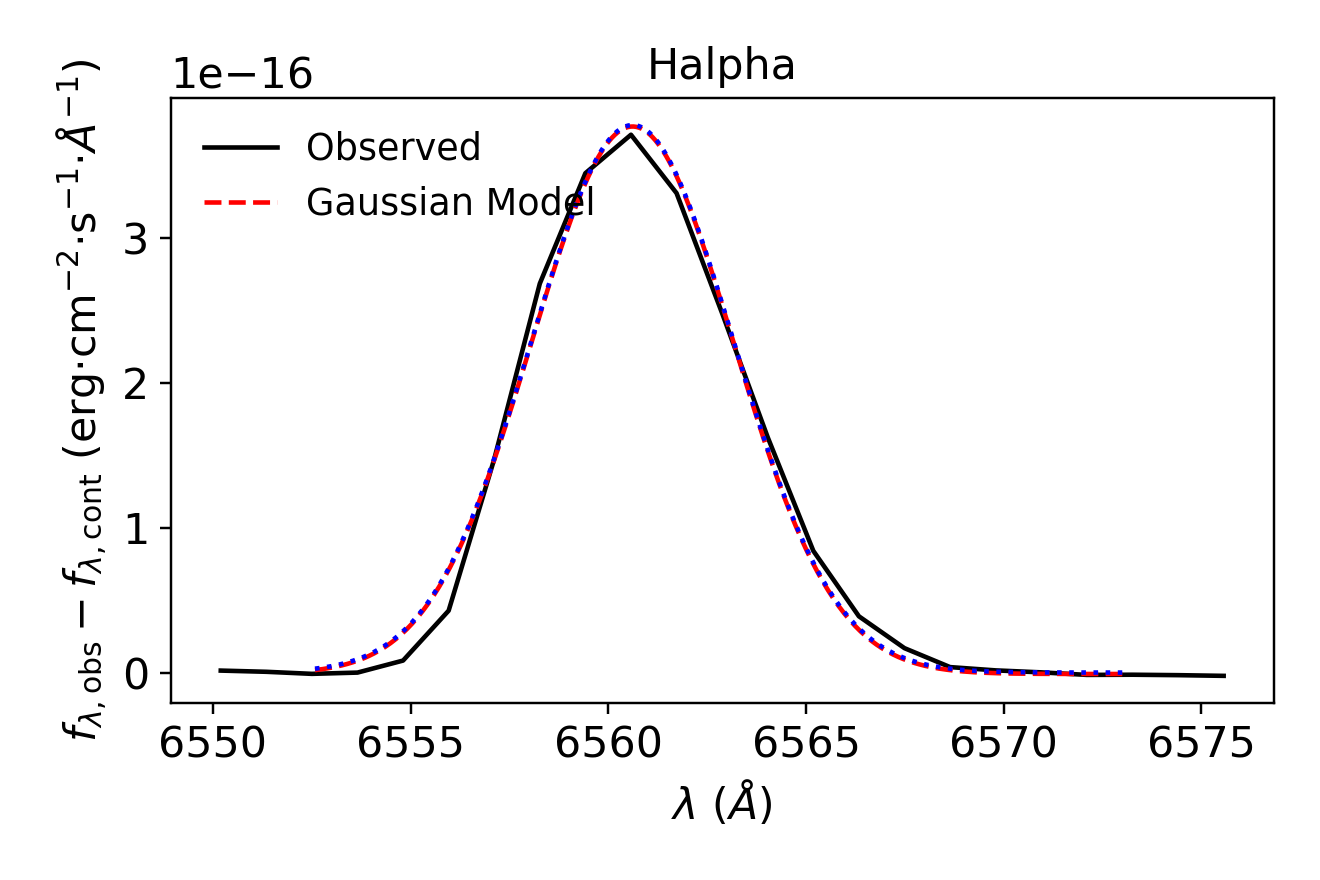

line flux of Halpha is: 24.15 +- 0.54 1e-16


In [55]:
flux_Halpha = measure_flux(dt6["wave_rest"], flux_line, line_center = H_list[-1],  sigma_guess = 2.5,
                           line_left = 13, line_right = 13, 
                           line_bound_width = 3., linename = "Halpha")

line width = 2.32 AA
line center is 4339.36 +- 0.24


<IPython.core.display.Javascript object>


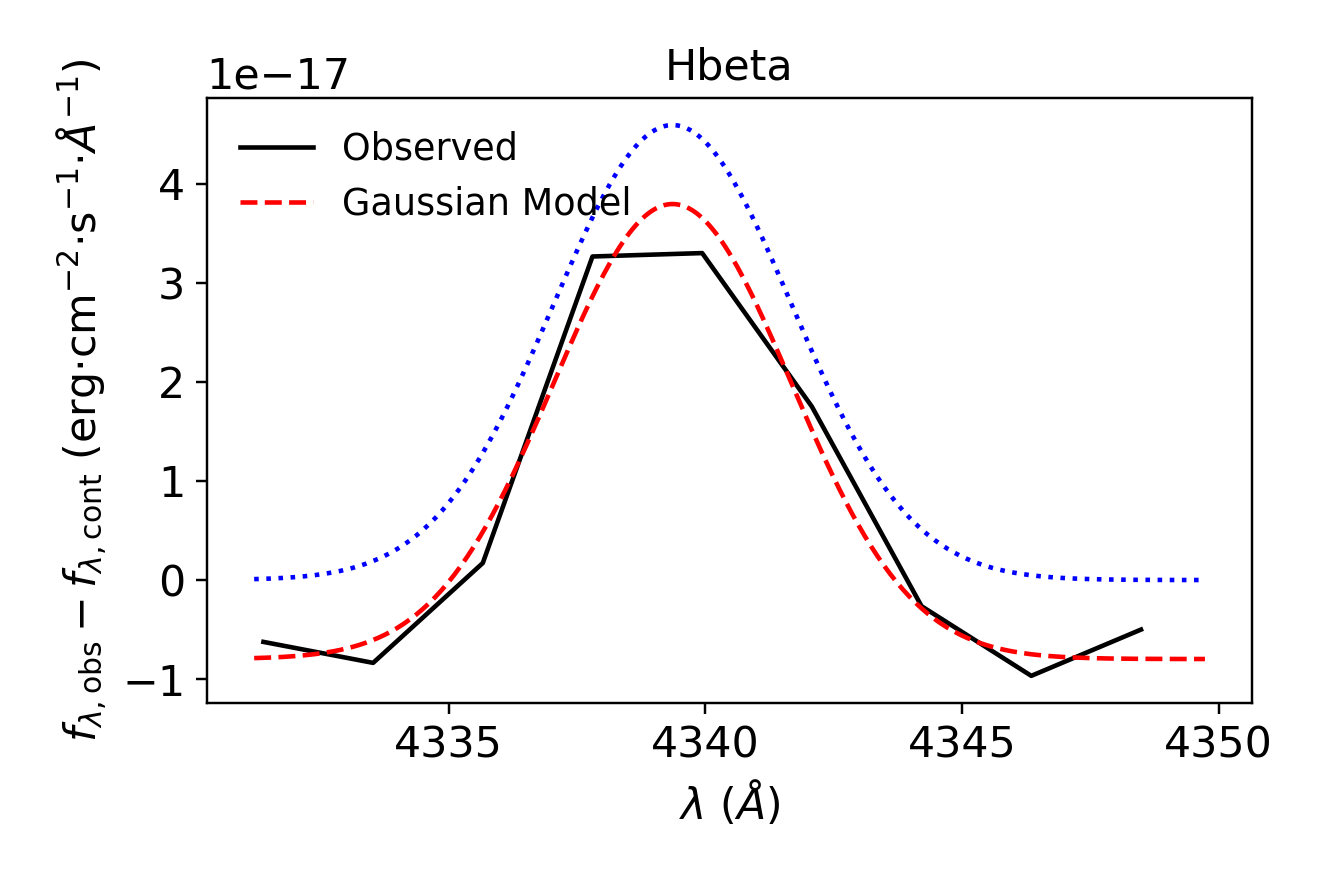

line flux of Hbeta is: 2.66 +- 0.32 1e-16


In [76]:
flux_Hbeta = measure_flux(dt6["wave_rest"], flux_line, line_center = H_list[2],  sigma_guess = 2.5,
                           line_left = 11, line_right = 10, 
                           line_bound_width = 3., linename = "Hbeta", a_width=0.3)

Some other lines

line width = 2.48 AA
line center is 5005.48 +- 0.11


<IPython.core.display.Javascript object>


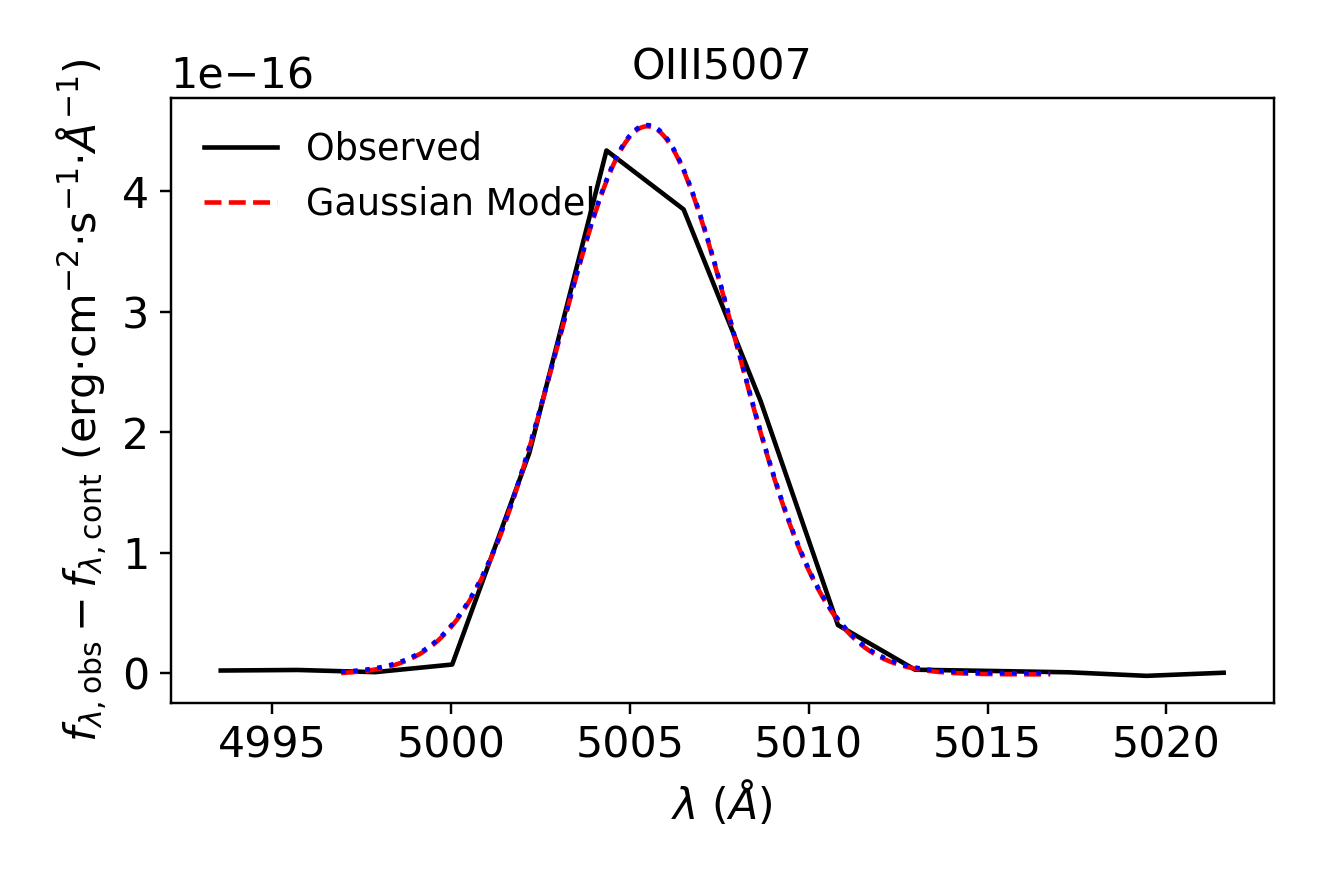

line flux of OIII5007 is: 28.24 +- 1.42 1e-16


In [58]:
flux_5007 = measure_flux(dt6["wave_rest"], flux_line, line_center = OIII_list[-1],  sigma_guess = 3,
                              line_bound_width = 3., linename = "OIII5007",
                              line_left = 15, line_right = 15)

line width = 2.72 AA
line center is 6581.49 +- 0.13


<IPython.core.display.Javascript object>


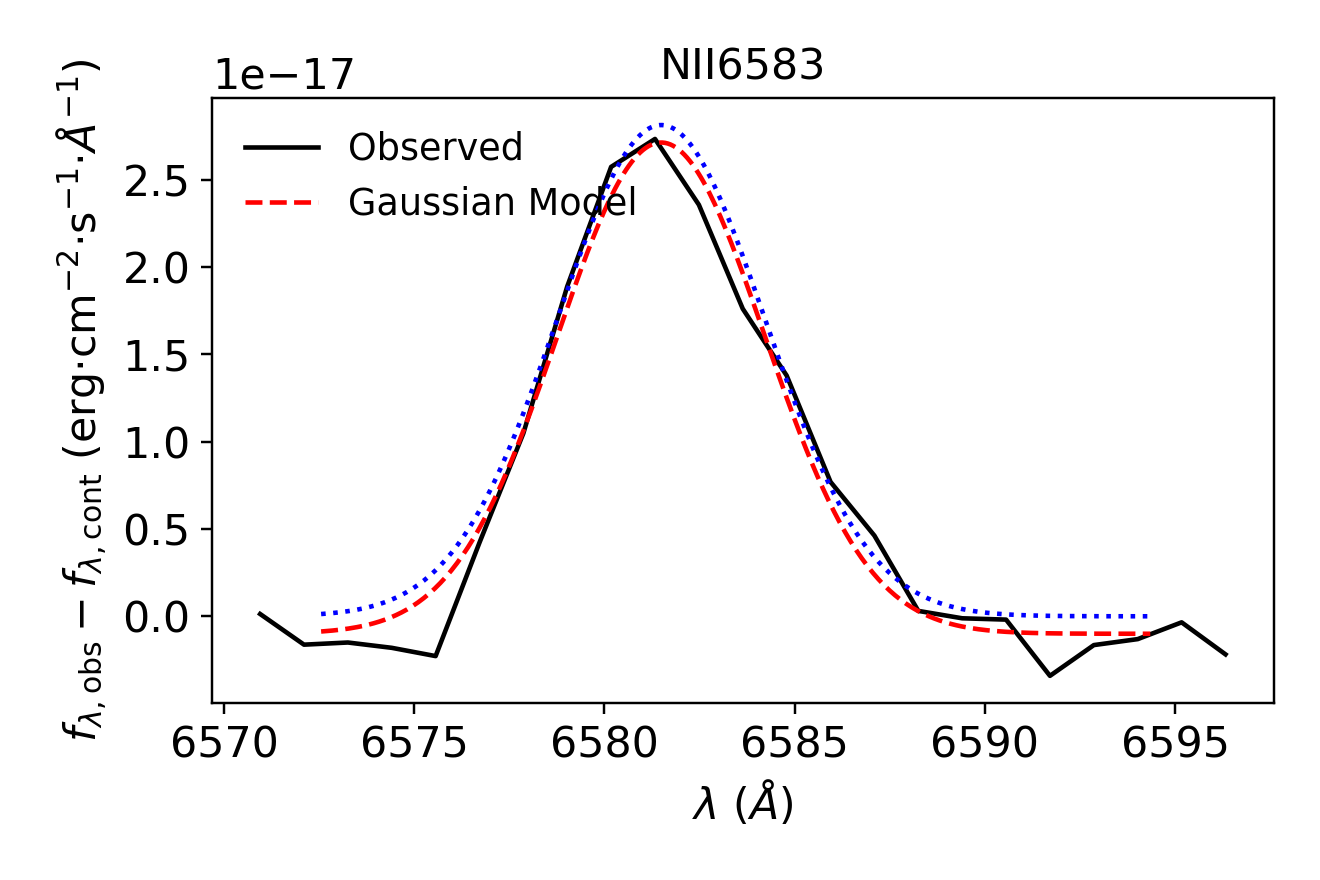

line flux of NII6583 is: 1.92 +- 0.10 1e-16


In [59]:
flux_6583 = measure_flux(dt6["wave_rest"], flux_line, line_center = NII_list[-1],  sigma_guess = 2.4,
                              line_bound_width = 4., linename = "NII6583",
                              line_left = 13, line_right = 13)

### Just in case: Convert line ratio to extinction (assume Case B recombination)
From Osterbrock & Ferland, Table 4.4. Let us use the value at $T=10000\,{\rm K}$ and $n_e = 100\,{\rm cm^{-3}}$. Then the line ratio should be 2.863.

Therefore, we have
\begin{equation}
2.863 \times {\rm exp}(-(\tau_{\rm H\alpha}-\tau_{\rm H\beta})) = 3.538 \\
2.863 \times {\rm exp}(-(A_{\rm H\alpha}-A_{\rm H\beta})/1.086) = 3.538 \\
(A_{\rm H\beta}-A_{\rm H\alpha}) = {\rm ln}(3.538/2.863)\times 1.086 \\
\end{equation}

## 2. Metallicity Indicators

### N2 scale
Following Marino et al. (2013), the Oxygen abundance in the N2 scale is (Eq. 4)
\begin{equation}
12 + {\rm log(O/H)} = 8.743[\pm0.027] + 0.462[\pm 0.024]\times {\rm N2}
\end{equation}

In [60]:
N2 = np.log10(flux_6583["flux"] / flux_Halpha["flux"])
N2_unc = np.sqrt(flux_6583["flux_unc"]**2/flux_6583["flux"]**2+flux_Halpha["flux_unc"]**2/flux_Halpha["flux"]**2)/np.log(10)

In [61]:
# statistical uncertainty
N2_unc * 0.462

0.011174551632272819

In [62]:
# systematic uncertainty
0.027 + 0.024*abs(N2)

0.05339070250100684

In [63]:
# O abundance 
8.743 + 0.462 * N2

8.234978976855619

### O3N2 scale

Following Marino et al. (2013), the Oxygen abundance in the O3N2 scale is (Eq. 2)
\begin{equation}
12 + {\rm log(O/H)} = 8.743[\pm0.027] + 0.462[\pm 0.024]\times {\rm N2}
\end{equation}

## 3. Star Formation rate
Use Kennicutt et al. (1992), Eq (2):
    \begin{equation}
    {\rm SFR}(M_\odot\,{\rm yr^{-1}}) = 0.63\times \frac{L({\rm H}\alpha)}{1.26 \times 10^{41}\,{\rm erg\,s^{-1}}}.
    \end{equation}
The factor of 0.63 is added from Madau & Dickinson (https://arxiv.org/abs/1403.0007) to convert the Salpeter to a Chabrier IMF.

In [64]:
pre_factor = 0.63 * 4*np.pi*(const.pc.cgs.value * D)**2/ 1.26e+41

In [65]:
SFR = pre_factor * flux_Halpha["flux"]
SFR_unc = SFR * np.sqrt((flux_Halpha["flux_unc"]/flux_Halpha["flux"])**2)

In [66]:
SFR

0.012429222132061303

In [67]:
SFR_unc

0.0002804637725113758

## 4. Electron Temperature and number density

I choose to use the measured [O III] 4363 / [O III] 5007 as a temperature diagnostics. We can show (Draine Chap 18) that in the low density limit ($n_e \ll n_{\rm crit}$), this ratio:
\begin{equation}
    \frac{{^1}S_{0} - {^1}D_{2}}{{^1}D_{2} - {^3}P_{2}} = \frac{1.34}{9.03\times {\rm exp}\left( \frac{3.3\times 10^4}{{\rm T (K)}} \right) \times  +1} \times \frac{5006.84}{4363.21}
\end{equation}
only depends on temperature. 

In order to calculate this more accurately let us use the `pyneb` package.